In [3]:
import shutil
import os
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.transforms.functional import to_tensor

# dataset root
data_root = "../data/raw"

# train annotation + images
train_json = os.path.join(data_root, "train", "annotations.json")
train_img_dir = os.path.join(data_root, "train", "images")

# load coco annotations
with open(train_json, "r") as f:
    train_data = json.load(f)

print("loaded train annotations:", len(train_data["images"]))


loaded train annotations: 2816


In [4]:
# augmentation pipeline applied dynamically during training
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
    ),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.2),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=3)  # mild rotation to preserve bboxes
    ], p=0.3),

    transforms.ToTensor()
])


In [5]:
def load_image(idx):
    """load COCO-format image by index."""
    img_info = train_data["images"][idx]
    img_path = os.path.join(train_img_dir, img_info["file_name"])
    return Image.open(img_path).convert("RGB"), img_info["file_name"]


def show_augmentations(index, num_samples=4):
    """visualize multiple augmentations of a single image."""
    img, file_name = load_image(index)

    print("original:", file_name)

    plt.figure(figsize=(12, 6))
    plt.suptitle("augmented samples")

    for i in range(num_samples):
        aug_img = train_transforms(img)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(aug_img.permute(1, 2, 0))
        plt.axis("off")

    plt.show()


original: 000001.jpg


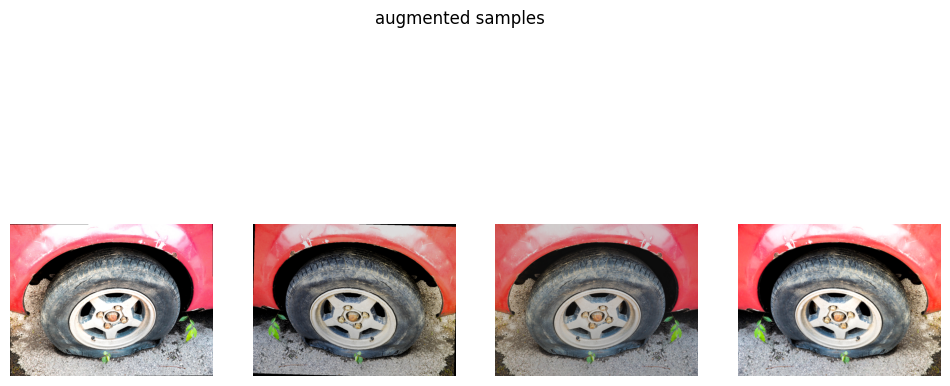

In [6]:
show_augmentations(0, num_samples=4)


In [7]:
# count annotations per class
class_counts = {}
for ann in train_data["annotations"]:
    cid = ann["category_id"]
    class_counts[cid] = class_counts.get(cid, 0) + 1

print("class frequencies:", class_counts)

# compute augmentation multiplier
max_count = max(class_counts.values())

aug_factor = {
    cid: max(1, max_count // count)   # more aug for smaller classes
    for cid, count in class_counts.items()
}

print("augmentation multiplier per class:", aug_factor)


class frequencies: {2: 2560, 6: 225, 3: 651, 1: 1806, 5: 494, 4: 475}
augmentation multiplier per class: {2: 1, 6: 11, 3: 3, 1: 1, 5: 5, 4: 5}


In [8]:
# updated output root (your requirement)
output_root = "../data/augmented/classification"
output_img_dir = os.path.join(output_root, "train", "images")
output_ann_dir = os.path.join(output_root, "train", "annotations")

# recreate folders cleanly
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_ann_dir, exist_ok=True)

# copy annotation file
shutil.copy(train_json, output_ann_dir)

print("saving augmented images...")

for img_info in train_data["images"]:
    file_name = img_info["file_name"]
    img_path = os.path.join(train_img_dir, file_name)

    # find class of image
    anns = [a for a in train_data["annotations"] if a["image_id"] == img_info["id"]]
    if len(anns) == 0:
        continue

    class_id = anns[0]["category_id"]
    multiplier = aug_factor[class_id]

    # load original
    img = Image.open(img_path).convert("RGB")

    # save original
    img.save(os.path.join(output_img_dir, file_name))

    # oversampling via augmentation
    for i in range(multiplier):
        aug_img_tensor = train_transforms(img)
        aug_img = transforms.ToPILImage()(aug_img_tensor)

        new_name = file_name.replace(".jpg", f"_aug{i+1}.jpg")
        aug_img.save(os.path.join(output_img_dir, new_name))

print("done. augmented classification dataset saved.")


saving augmented images...
done. augmented classification dataset saved.


In [9]:
class_counts_after = {} # class distribution after augmentation

# original images count as 1 each
for ann in train_data["annotations"]:
    cid = ann["category_id"]
    class_counts_after[cid] = class_counts_after.get(cid, 0) + 1

# add augmented counts
for ann in train_data["annotations"]:
    cid = ann["category_id"]
    multiplier = aug_factor[cid]
    class_counts_after[cid] += multiplier   # each original adds N augmented

print("\n🔹 Class distribution AFTER oversampling + augmentation:")
for cid, count in sorted(class_counts_after.items()):
    print(f"  Class {cid}: {count} samples (augmented)")



🔹 Class distribution AFTER oversampling + augmentation:
  Class 1: 3612 samples (augmented)
  Class 2: 5120 samples (augmented)
  Class 3: 2604 samples (augmented)
  Class 4: 2850 samples (augmented)
  Class 5: 2964 samples (augmented)
  Class 6: 2700 samples (augmented)
